In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import urllib
from bs4 import BeautifulSoup
import requests
import nexmo
import time

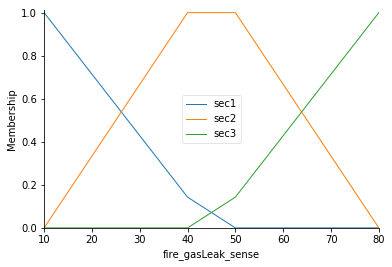

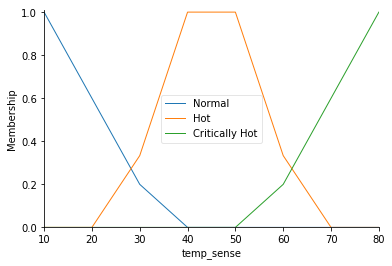

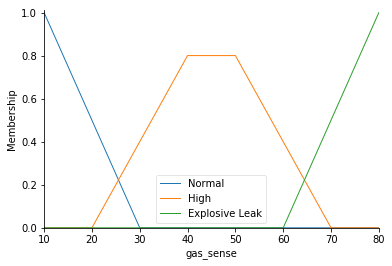

In [3]:

#----------------------Fuzzy Inference System(Mamdani)----------------------------------------

#I/p fuzzy sets
temp_sense = ctrl.Antecedent(np.arange(10, 90, 10), 'temp_sense')
gas_sense = ctrl.Antecedent(np.arange(10, 90, 10), 'gas_sense')

#O/p fuzzy set
fire_gasLeak_sense = ctrl.Consequent(np.arange(10, 90, 10), 'fire_gasLeak_sense')

#Membership functions

#temp_sense.automf(3)
#gas_sense.automf(3)
#fire_gasLeak_sense.automf(3)

temp_sense['Normal'] = fuzz.trimf(fire_gasLeak_sense.universe, [0, 10, 35])
temp_sense['Hot'] = fuzz.trapmf(fire_gasLeak_sense.universe, [25,40,50,65])
temp_sense['Critically Hot'] = fuzz.trimf(fire_gasLeak_sense.universe,[55,80,80])

gas_sense['Normal'] = fuzz.trimf(fire_gasLeak_sense.universe, [0, 10, 30])
gas_sense['High'] = fuzz.trimf(fire_gasLeak_sense.universe, [20,45, 70])
gas_sense['Explosive Leak'] = fuzz.trimf(fire_gasLeak_sense.universe, [60,80,80])

#Membership functions for fire/gasLeak fuzzy set
fire_gasLeak_sense['sec1'] = fuzz.trimf(fire_gasLeak_sense.universe, [0, 10, 45])
fire_gasLeak_sense['sec2'] = fuzz.trapmf(fire_gasLeak_sense.universe, [10, 40, 50, 80])
fire_gasLeak_sense['sec3'] = fuzz.trimf(fire_gasLeak_sense.universe,[45 , 80, 80])
#fire_gasLeak_sense['Sec4'] = fuzz.trimf(fire_gasLeak_sense.universe, [35, 45, 60])

fire_gasLeak_sense.view()
temp_sense.view()
gas_sense.view()

#RULE base
rule1 = ctrl.Rule(temp_sense['Normal'] & gas_sense['Normal'], fire_gasLeak_sense['sec1'])
rule2 = ctrl.Rule(temp_sense['Normal'] & gas_sense['High'], fire_gasLeak_sense['sec2'])
rule3 = ctrl.Rule(temp_sense['Normal'] & gas_sense['Explosive Leak'], fire_gasLeak_sense['sec3'])
rule4 = ctrl.Rule(temp_sense['Hot'] & gas_sense['Normal'], fire_gasLeak_sense['sec1'])
rule5 = ctrl.Rule(temp_sense['Hot'] & gas_sense['High'] , fire_gasLeak_sense['sec2'])
rule6 = ctrl.Rule(temp_sense['Hot'] & gas_sense['Explosive Leak'], fire_gasLeak_sense['sec3'])
rule7 = ctrl.Rule(temp_sense['Critically Hot'] & gas_sense['Normal'], fire_gasLeak_sense['sec3'])
rule8 = ctrl.Rule(temp_sense['Critically Hot'] & gas_sense['High'], fire_gasLeak_sense['sec3'])
rule9 = ctrl.Rule(temp_sense['Critically Hot'] & gas_sense['Explosive Leak'], fire_gasLeak_sense['sec3'])

#Creating a fuzzy control system using the rule base
FireGasLeak_ctrlSys = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5 , rule6, rule7, rule8, rule9])

#Creating a simulation for our Iot systems using the above created FCS
FgcsIot = ctrl.ControlSystemSimulation(FireGasLeak_ctrlSys)

#----------------------------------------------------------------------------------------

#-------------------------------------ThingSpeak-&-TalkBack------------------------------

url = "Insert_Your_Thingspeak_TalkBack_URL" 
api_key = "Insert_Your_Thingspeak_TalkBack_API_KEY"
# Visit https://thingspeak.com/apps/talkbacks for more info.

dataAlarmON1 = {"api_key":api_key,"command_string":"ON1","position":"1"}   # data for ON commands
dataAlarmON2 = {"api_key":api_key,"command_string":"ON2","position":"1"}
dataAlarmON3 = {"api_key":api_key,"command_string":"ON3","position":"1"}
dataAlarmOff = {"api_key":api_key,"command_string":"OFF","position":"1"}   # data for OFF command



In [4]:

def periodic_work(interval):
    while True:
        # (GET requests) to retrieve temperature and gas field values . 'results=1' in request indicates most recent values
        # Channel ID, field no. and ThingSpeak Read API keys have to be specified in URL
        # All required info can be found on https://thingspeak.com/channels
        tempField_data=urllib.urlopen("https://api.thingspeak.com/channels/CHANNEL_ID/fields/1/last?api_key=READ_API_KEY&results=1");
        gasField_data=urllib.urlopen("https://api.thingspeak.com/channels/CHANNEL_ID/fields/2/last?api_key=READ_API_KEY&results=1");
        
        x=float(tempField_data.read())
        y=float(gasField_data.read())
        print("temp=",x,"  ,gas=",y)
        #Setting the i/ps for i/p fuzzy sets as the data read from the above fields
        FgcsIot.input['temp_sense']=x
        FgcsIot.input['gas_sense']=y*100 #mul by 100 to normalize

        FgcsIot.compute()
        print (FgcsIot.output['fire_gasLeak_sense'])
        #fire_gasLeak_sense.view(sim=FgcsIot)
        
        #print()

        crispOP=FgcsIot.output['fire_gasLeak_sense'] #Crisp output
        # posting crisp output rounded to 2 decimal places, to channel
        time.sleep(14);
        # Insert ThingSpeak Write API key in the following url 
        urllib.urlopen("https://api.thingspeak.com/update?api_key=WRITE_API_KEY&field6="+str(round(crispOP,3)));

      # Nexmo SMS API
        client = nexmo.Client(key='Nexmo_Key', secret='Nexmo_Secret') # key and secret obtained through a nexmo subscription
        
        if crispOP<=26.67:
            #client.send_message({'from': 'Nexmo', 'to': 'Insert Mobile No', 'text': 'Normal'})
            print("01")
        if crispOP>26.67 and crispOP<=53.33:
            #client.send_message({'from': 'Nexmo', 'to': 'Insert Mobile No', 'text': 'High temp/gas levels'})
            print("10")
        if crispOP>53.33:
            #client.send_message({'from': 'Nexmo', 'to': 'Insert Mobile No', 'text': 'Critically High -  Gas Levels /Temperature.Immediate Action Required'})
            print("11")
        
        time.sleep(interval);


In [ ]:
# Running the function
periodic_work(55)

# Crisp output for inputs of temp and gas
('temp=', 71.1, '  ,gas=', 1.34)
66.73498401885462


In [1]:
# if-else code for IoTFuzzyFourStateTALKBACK

'''
        if crispO/P<=t1:
            requests.put(url,data=dataAlarmOn1)
            #client.send_message({'from': 'Nexmo', 'to': '971563201593', 'text': 'Emergency Shutdown Reqd'})
        
        elif crispO/P>t1 and crispO/P<=t2:
            requests.put(url,data=dataAlarmOn2)
            #client.send_message({'from': 'Nexmo', 'to': '971563201593', 'text': 'Situation:Critical'})
            
        elif crispO/P>t1 and crispO/P<=t2:
            requests.put(url,data=dataAlarmOn3)
            client.send_message({'from': 'Nexmo', 'to': '971563201593', 'text': 'Inspection Regd'})
            
        else:
            requests.put(url,data=dataAlarmOff)'''

"\n        if crispO/P<=t1:\n            requests.put(url,data=dataAlarmOn1)\n            #client.send_message({'from': 'Nexmo', 'to': '971563201593', 'text': 'Emergency Shutdown Reqd'})\n        \n        elif crispO/P>t1 and crispO/P<=t2:\n            requests.put(url,data=dataAlarmOn2)\n            #client.send_message({'from': 'Nexmo', 'to': '971563201593', 'text': 'Situation:Critical'})\n            \n        elif crispO/P>t1 and crispO/P<=t2:\n            requests.put(url,data=dataAlarmOn3)\n            client.send_message({'from': 'Nexmo', 'to': '971563201593', 'text': 'Inspection Regd'})\n            \n        else:\n            requests.put(url,data=dataAlarmOff)\n        "

45.0


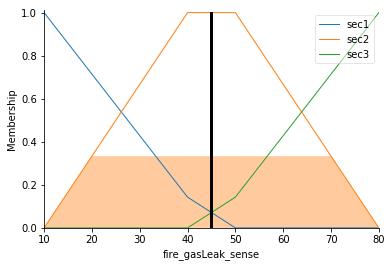

In [7]:
# A demo showing only the fuzzy inference system computing output based on sample input values of temperature and gas 
'''
#inputs
tempField_data=30
gasField_data=0.5

FgcsIot.input['temp_sense']=tempField_data
FgcsIot.input['gas_sense']=gasField_data*100

#computation
FgcsIot.compute()
#df2.ix[3,6]=FgcsIot.output['fire_gasLeak_sense']

#output
crispOP=FgcsIot.output['fire_gasLeak_sense'] #Crisp output
print(crispOP)
fire_gasLeak_sense.view(sim=FgcsIot)
'''